In [ ]:
# check for GPU connection
!nvidia-smi

Sun Mar 16 06:22:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

print("Path to dataset files:", path)

100%|██████████| 2.58G/2.58G [01:57<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1


In [ ]:
%cd /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)
%ls

/root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)
 Drowsy/  'Non Drowsy'/


In [ ]:
# import library to read image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

drowsy_path = 'Drowsy'
non_drowsy_path = 'Non Drowsy'

# Function to read images and assign labels
def read_images_with_labels(path, label):
    images = []
    labels = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Read images with labels
drowsy_images, drowsy_labels = read_images_with_labels(drowsy_path, 1)
non_drowsy_images, non_drowsy_labels = read_images_with_labels(non_drowsy_path, 0)

In [ ]:
from sklearn.model_selection import train_test_split

# zip drowsy_images+drowsy_label and non_drowsy_images+non_drowsy_label
all_images = list(zip(drowsy_images, drowsy_labels)) + list(zip(non_drowsy_images, non_drowsy_labels))

train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)

# shuffle data
np.random.shuffle(train_images)
np.random.shuffle(test_images)
np.random.shuffle(val_images)

print(len(train_images))
print(len(test_images))
print(len(val_images))

25075
8359
8359


In [ ]:
def show_images_with_label(images):
    plt.figure(figsize=(20,10))
    for i, (image, label) in enumerate(images[:10]):
        plt.subplot(2,5,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if label == 1:
            plt.title("Drowsy")
        else:
            plt.title("Non Drowsy")
    plt.tight_layout()
    plt.show()

show_images_with_label(train_images)

Output hidden; open in https://colab.research.google.com to view.

# **Facial Landmark with Dlib+openCV**

In [ ]:
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

# test function to view face landmark
def face_landmark(images):
    landmark_images = []
    for image, label in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            if landmarks is None:
                continue
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
            landmark_images.append((image, label)) # Append the modified image and label
    return landmark_images

face_landmark_test = face_landmark(train_images[:10])
show_images_with_label(face_landmark_test)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import scipy.spatial.distance as dist

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def compute_eye_aspect_ratios(shape):
    # Extract the coordinates for the left and right eyes.
    # Left eye: landmarks 42-47
    leftEye = [(shape.part(i).x, shape.part(i).y) for i in range(42, 48)]
    # Right eye: landmarks 36-41
    rightEye = [(shape.part(i).x, shape.part(i).y) for i in range(36, 42)]

    # Compute EAR for both eyes using the provided function.
    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    return leftEAR, rightEAR

def face_landmark_with_ear(images):
    ear_with_label = []
    for image, label in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            if landmarks is None:
                continue
            leftEAR, rightEAR = compute_eye_aspect_ratios(landmarks)
            ear = (leftEAR + rightEAR) / 2.0
            ear_with_label.append((ear, label))
    return ear_with_label

ear_images_with_label_train = face_landmark_with_ear(train_images)

In [ ]:
import pandas as pd

df = pd.DataFrame(ear_images_with_label_train, columns=['EAR', 'label'])
df.head()

,EAR,label
0,0.363247,1
1,0.244222,1
2,0.300166,1
3,0.221190,0
4,0.417228,1


In [ ]:
df.shape

(20087, 2)

In [ ]:
df.describe()

,EAR,label
count,20087.000000,20087.000000
mean,0.265475,0.527406
std,0.080156,0.499261
min,0.058395,0.000000
25%,0.207911,0.000000
50%,0.255253,1.000000
75%,0.304086,1.000000
max,0.515119,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20087 entries, 0 to 20086
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EAR     20087 non-null  float64
 1   label   20087 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 314.0 KB


<Axes: xlabel='EAR', ylabel='Count'>

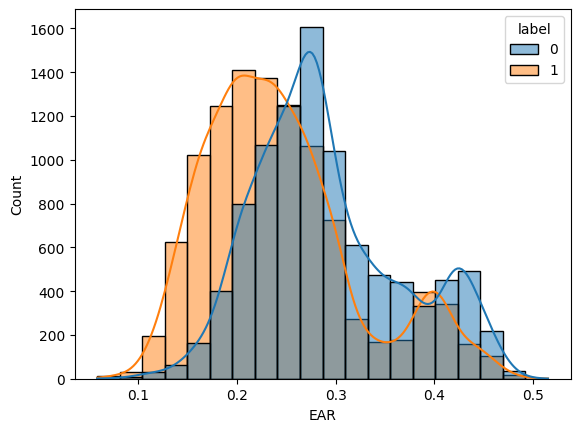

In [ ]:
import seaborn as sns

sns.histplot(data=df, x='EAR', hue='label', bins=20, kde=True)

In [ ]:
df_test = pd.DataFrame(face_landmark_with_ear(test_images), columns=['EAR', 'label'])
df_val = pd.DataFrame(face_landmark_with_ear(val_images), columns=['EAR', 'label'])

# **SVM**

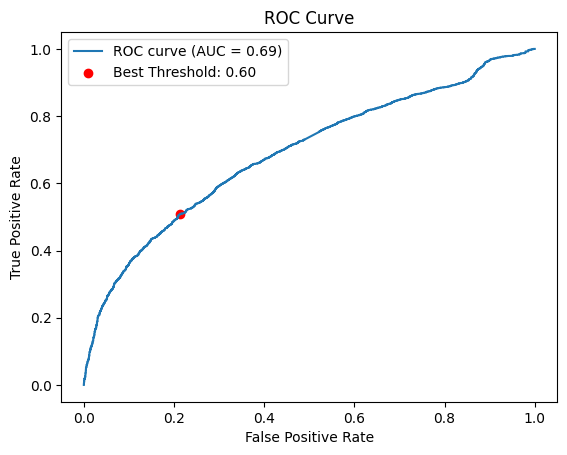

Optimal Threshold: 0.60


In [ ]:
import sklearn.svm as svm
from sklearn.metrics import roc_curve, precision_recall_curve, auc ,roc_auc_score

model = svm.SVC(C=1, kernel='linear',  probability=True)
model.fit(df['EAR'].values.reshape(-1, 1), df['label'])

# get prediction probabilities
y_pred_prob = model.predict_proba(df_test['EAR'].values.reshape(-1, 1))[:, 1]

# compute ROC curve
fpr, tpr, thresholds = roc_curve(df_test['label'], y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)  # Youden’s J statistic
optimal_threshold = thresholds[optimal_idx]

# plot the curve
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(auc(fpr, tpr)))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f"Best Threshold: {optimal_threshold:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.2f}")

In [ ]:
# test the model accuracy
from sklearn.metrics import accuracy_score

y_pred_custom = (y_pred_prob >= optimal_threshold).astype(int)
accuracy = accuracy_score(df_test['label'], y_pred_custom)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


In [ ]:
print('optimal threshold: ', optimal_threshold)
print(y_pred_prob)
print(y_pred_custom)

optimal threshold:  0.5952715387509916
[0.68711485 0.50547714 0.32850657 ... 0.46310894 0.54992613 0.51741613]
[1 0 0 ... 0 0 0]


In [ ]:
%ls

 Drowsy/  'Non Drowsy'/   svm_drowsiness_model.pkl


In [ ]:
# download model
from google.colab import files

files.download('svm_drowsiness_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],   # Regularization parameter
    'gamma': ['scale', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly']  # Different kernel types
}

# Perform Grid Search with Cross-Validation
svm = SVC(probability=True)  # Enable probability for threshold tuning later
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(df['EAR'].values.reshape(-1,1), df['label'])

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Train the final model with best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(df['EAR'].value.reshape(-1,1), df['label'])

# Evaluate on Test Set
test_accuracy = best_svm.score(df_test['EAR'].value.reshape(-1,1), df_test['label'])
print("Test Accuracy:", test_accuracy)

KeyboardInterrupt: 